# Road Lane Detection 

Objective:  Lane Detection from images

1- Before detecting lanes from videos,initially we'll start working with images and import opencv, numpy and matplotlib packages.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

2- We'll start by building the program in order to work on images in the directory "Images".

In [0]:
import os
PATH = "Images"
test_imgs = os.listdir(PATH)
test_imgs

3- Now, we'll define a function "display_imgs" that will display multiple images.


In [0]:
import scipy.misc
def display_imgs(img_list, labels=[],cols=2, fig_size=(10,5)):
    if len(labels) > 0:
        assert(len(img_list) == len(labels))
    assert(len(img_list) > 0)
    cmap = None
    tot = len(img_list)
    rows = tot / cols
    plt.figure(figsize=fig_size)
    for i in range(tot):
        plt.subplot(rows, cols, i+1)
        if len(img_list[i].shape) == 2:
            cmap = 'gray'
        if len(labels) > 0:
            plt.title(labels[i])
        plt.imshow(img_list[i], cmap=cmap)
        
    plt.tight_layout()
    plt.show()

4- Here, we define a function "save_imgs" that make copies into the Images_output directory.

In [0]:
from PIL import Image

def save_imgs(img_list, labels, mode='RGB', prefix="Test", op_folder="Images_output"):
    if not os.path.exists(op_folder):
        os.mkdir(op_folder)
    for img, label in zip(img_list, labels):
        PATH = op_folder + "/" + prefix + "_" + label
        Image.fromarray(img, mode=mode).save(PATH)

5 - Displaying original Images

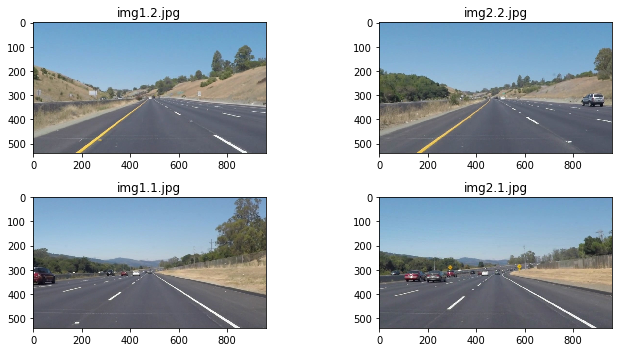

In [0]:
def read_img(img):
    return mpimg.imread(img)
img_list = [read_img(PATH +"/" + name) for name in test_imgs]
display_imgs(img_list, test_imgs)
save_imgs(img_list, test_imgs, prefix= "Original")

6- Converting original images to grayscale.

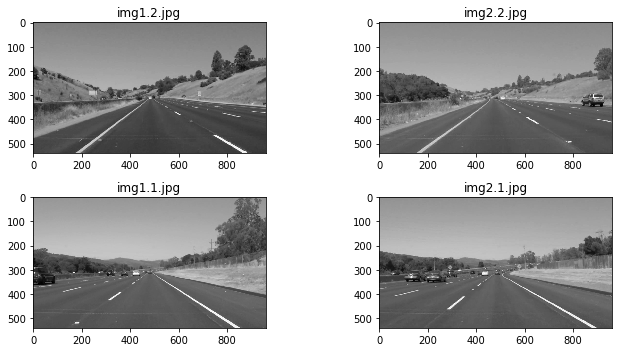

In [0]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray_imgs = [grayscale(img) for img in img_list]
display_imgs(gray_imgs, test_imgs)
save_imgs(gray_imgs, test_imgs, prefix="Gray", mode='L')

7 - There are many regions of road that are not colored. In order to reduce the contrast from these regions, we will darken the grayscale images. To do this we will define a function "adjust_gamma" in order to apply gamma correction using the lookup table.

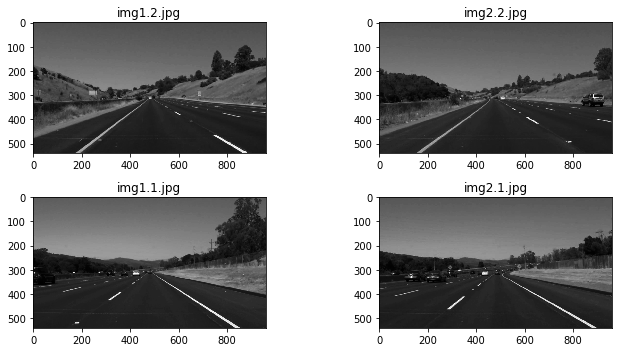

In [0]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
darkened_imgs = [adjust_gamma(img, 0.5) for img in gray_imgs]
display_imgs(darkened_imgs, test_imgs)
save_imgs(darkened_imgs, test_imgs, prefix="Darkened", mode='L')

8 - Now we'll convert original image to HLS colour space.
Original images are in RGB, but we'll also explore other colour spaces like HSV and HLS. Start by displaying images in the three color spaces RGB, HSV and HLS.

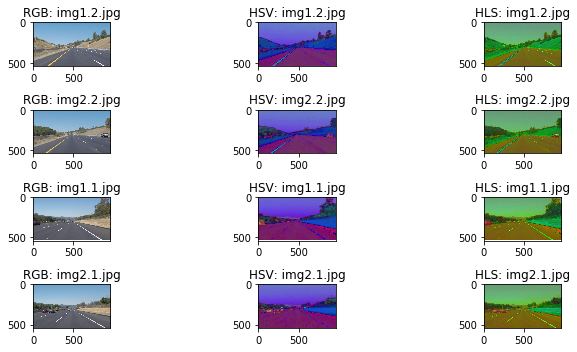

In [0]:
def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

diff_color_spaces_imgs = []
diff_color_spaces_labels = []
for i in range(len(img_list)):
    diff_color_spaces_imgs.append(img_list[i])
    diff_color_spaces_labels.append("RGB: " +test_imgs[i])
    diff_color_spaces_imgs.append(to_hsv(img_list[i]))
    diff_color_spaces_labels.append("HSV: " +test_imgs[i])
    diff_color_spaces_imgs.append(to_hls(img_list[i]))
    diff_color_spaces_labels.append("HLS: " +test_imgs[i])
    
display_imgs(diff_color_spaces_imgs, diff_color_spaces_labels, cols=3)
original_imgs = np.copy(img_list)

9 - When looked to pictures above, we can easily see that we can get better colour contrast in HLS colour space. This may help us to have better colour selection and then better lane detection.
So let's convert images to HLS color space.
Start by isolating yellow from HLS to get yellow mask(for yellow lane markings)and white from HLS to get white mask(for white lane markings).
We'll use the following range for threshold:
* For white mask:
and we'll use higher lightness value (200–255).
* For yellow mask: 
Hue between 10 and 40 and use higher saturation value(100–255) to avoid yellow from hills.

In [0]:
def isolate_color_mask(img, low_thresh, high_thresh):
    assert(np.all(low_thresh >=0  and low_thresh <=255))
    assert(high_thresh.all() >=0 and high_thresh.all() <=255)
    return cv2.inRange(img, low_thresh, high_thresh)

white_masks = []
yellow_masks = []
white_masks = [isolate_color_mask(to_hls(img), np.array([0, 200, 0], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)) for img in original_imgs]
yellow_masks = [isolate_color_mask(to_hls(img), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8)) for img in original_imgs]
masked_imgs = []

10 - Using OpenCV’s functions
* "cv2.bitwise_or()" to bitwise or yellow and white masks to get common mask. 
* "cv2.bitwise_and()" to bitwise and mask with darkened image.


In [0]:
for i in range(len(original_imgs)):
    mask = cv2.bitwise_or(white_masks[i], yellow_masks[i])
    masked_imgs.append(cv2.bitwise_and(darkened_imgs[i], darkened_imgs[i], mask=mask))

display_imgs(masked_imgs, test_imgs)
save_imgs(masked_imgs, test_imgs, prefix='Color_Mask', mode='L')

11- Now we use OpenCV's function "gaussian_blur()" in order to reduce the noise, we will use an odd value for kernel size and  try some values in order to choose the best one.

In [0]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
blurred_imgs = [gaussian_blur(img, kernel_size=7) for img in masked_imgs]
display_imgs(blurred_imgs, test_imgs)
save_imgs(blurred_imgs, test_imgs, prefix='Gaussian', mode='L')

12 - Now it is time to get edges from Gaussian blurred images. Using OpenCV's function "cv2.Canny()" in order to apply Canny Edge Detector.

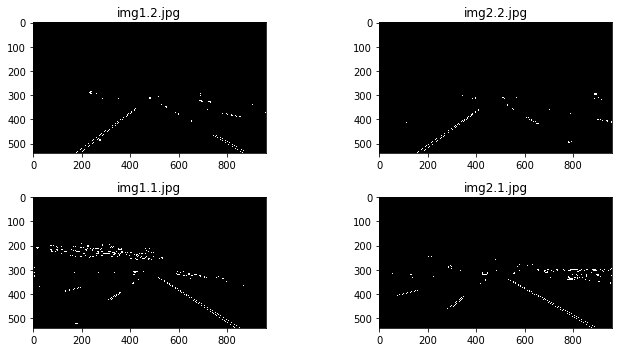

In [0]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)
canny_imgs = [canny(img, low_threshold=70, high_threshold=140) for img in blurred_imgs]
display_imgs(canny_imgs, test_imgs)
save_imgs(canny_imgs, test_imgs, prefix='Canny', mode='L')

13 - In order to weed out unwanted edges detected by canny edge detector in the previous step,we should select Region of Interest(which is a polygon that defines area in the image, from where edges we are interested).
The co-ordinate origin in the image is top-left corner of image. Rows co-ordinates increase top-down and Column co-ordinates increase left-right.

In [0]:
aoi_imgs = []

def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    plt.imshow(mask)
    return cv2.bitwise_and(img, mask)
    
for img in canny_imgs:        
    aoi_imgs.append(get_aoi(img))
    
display_imgs(aoi_imgs, test_imgs)
save_imgs(aoi_imgs, test_imgs, prefix='AOI', mode='L')

14- <b> Hough Transformation Lines Detection</b>
Hough Transform is the technique to find out lines by identifying all points on the line. This is done by representing a line as point. And points are represented as lines/sinusoidal(depending on Cartesian / Polar co-ordinate system). If multiple lines/sinusoidal pass through the point , we can conclude that these points lie on the same line.

In [0]:
def get_hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=300):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

15 - Defining a function "draw_lines" using OpenCV's function "cv2.line()" in order to average/extrapolate the line segments you detect to map out the full extent of the lane.

In [0]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
            
    return img

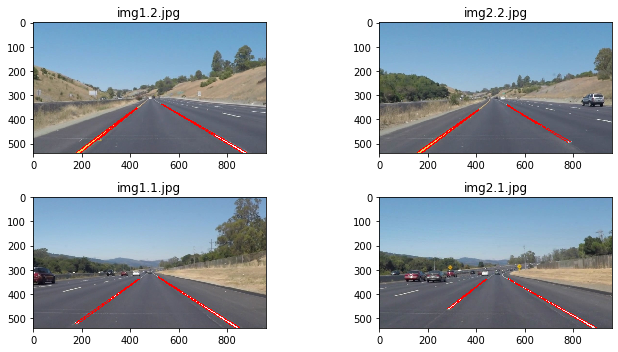

In [0]:
hough_lines_imgs = []
lines = []
for img in aoi_imgs:
    lines.append(get_hough_lines(img))
    
for img, line in zip(original_imgs, lines):
    hough_lines_imgs.append(draw_lines(img, line))
    
display_imgs(hough_lines_imgs, test_imgs)
save_imgs(hough_lines_imgs, test_imgs, prefix='Hough', mode='RGB')

16- To have a better result. We will consolidate and extrapolate lines.
To do this, 
* We need to distinguish between left lane and right lane. 
The left lane lines should have negative slope(As the values of column co-ordinate increases , the values of rows co-ordinate decreases. So the gradient must be negative). The right lane lines should have positive slope(As the values of column co-ordinate increases , the values of rows co-ordinate increases. So the gradient must be positive).
* We should ignore the vertical lines(denominator in slope 0).
* Then, we'll extrapolate lines (If there are many lines detected for Lane, average the lines and if there are some partially detected lines, extrapolate them).

In [0]:
def get_lane_lines(hough_lines):
  left_lane_lines = []
  right_lane_lines = []
  for line in hough_lines[:,0,:]:
    x1, y1, x2, y2 = line
    if x1 == x2:
      continue
    if (y1 - y2)/(x1 - x2) < 0:
      right_lane_lines.append(line)
    else:
      left_lane_lines.append(line)
  return np.mean(left_lane_lines,axis=0), np.mean(right_lane_lines,axis=0)

hough_lines = get_hough_lines(aoi_imgs[0])
get_lane_lines(hough_lines)

(array([554.16666667, 351.16666667, 839.66666667, 518.16666667]),
 array([245.375, 496.375, 411.25 , 365.375]))